# Figure 5a

This notebook loads the data and produces figure 5a. The intermediate file "figure5a_clusters_bystate.csv" is saved here and reloaded to be used for the figure. You can reproduce the figure starting from that point in the code by downloading "figure5a_clusters_bystate.csv" from our data repository. You will need to separately download the shape files https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2024.html.

In [1]:
plotsavedate = '20251031'

In [2]:
data_folder = '' # path to data - not needed for you to rerun figure
geodata_folder = '' # save the shape file folders here
figure_data_folder = '' # save the data from the data repository here in a subfolder called "FigureData"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import numpy as np
# import copy
import us
import state_name_crs_mappings_ML as crsm
import geopandas as geopd

## Load Data

In [4]:
# Load cluster labels
all_labels = pd.read_csv(data_folder + 'clustering_labels_saved_20251031.csv', index_col=0)

# Load station-level data (for mapping of cluster label to state)
string_cols = ['unique_ID', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State_abbr', 'ZIP',  'Status Code', 'EV Network', 'Owner Type Code', 'Open Date',  'EV Pricing', 'Facility Type', 'Groups With Access Code',  'Access Days Time', 'COUNTYNAME', 'State',  'clostestname_PoI', 'clostestname_ind', 'clostestname_topcat', 'utility', 'utilitytype', 'STATEFP']
dtype_dict = {i:'string' for i in string_cols}
combined_df_stations = pd.read_csv(data_folder + '20_level_stations_US_compiled_250415.zip', index_col=0,
                                         dtype=dtype_dict, usecols=['unique_ID', 'Station Name', 'Street Address', 'City', 'State', 'ZIP'])

# Combine
combined_df_stations = combined_df_stations.merge(all_labels, on='unique_ID', how='outer')
combined_df_stations = combined_df_stations.reset_index()

## Save and reload 
Then the following plotting script can be run by anyone using the posted data.

In [5]:
# Save key data of stations in each cluster in each state
allstates_data = pd.DataFrame()
for state in combined_df_stations['State'].unique():
    ct_dict = combined_df_stations[combined_df_stations['State']==state]['Kmeans_nc8'].value_counts()
    ct_dict2 = {i:ct_dict[i] if i in ct_dict.keys() else 0 for i in range(8)}
    tmp = pd.DataFrame(ct_dict2, index=[state]).T
    allstates_data = pd.concat((allstates_data, tmp), axis=1)
    
# Add "paper cluster labels" so someone downloading the data can read the labels
allstates_data.index = allstates_data.index.set_names(['Kmeans_nc8'])
allstates_data = allstates_data.reset_index()

cluster_order_numbers8_v3 = [1, 3, 5, 2, 6, 7, 4, 0]
map_kmeans_to_paper = {j:i+1 for i, j in enumerate(cluster_order_numbers8_v3)}
map_paper_to_kmeans = {j:i for i, j in map_kmeans_to_paper.items()}

for i in allstates_data.index:
    allstates_data.loc[i, 'paper_cluster_labels'] = map_kmeans_to_paper[allstates_data.loc[i, 'Kmeans_nc8']]
allstates_data['paper_cluster_labels'] = allstates_data['paper_cluster_labels'].astype(int)

# Save
allstates_data.to_csv(figure_data_folder + 'FigureData/figure5a_clusters_bystate.csv', index=None)

### Run from here if reloading data

In [6]:
# Reload
allstates_data = pd.read_csv(figure_data_folder + 'FigureData/figure5a_clusters_bystate.csv', index_col='Kmeans_nc8')

In [7]:
# Load map
gdf_state = geopd.read_file(geodata_folder + 'cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1])
gdf_state = gdf_state.to_crs(epsg=crs)

# Separate AK and HI
gdf_ak = gdf_state[gdf_state['STUSPS']=='AK'].copy()
gdf_hi = gdf_state[gdf_state['STUSPS']=='HI'].copy()

# Separate lower 48 + DC
full_state_list = [state.abbr for state in us.states.STATES]
state_list_lower48 = [k for k in full_state_list if k not in ['HI', 'AK']]
fips_all = [us.states.lookup(state).fips for state in state_list_lower48]
ordered_states = list(combined_df_stations.groupby('State').count().sort_values(by='unique_ID', ascending=False).index.values)
gdf_state = gdf_state[gdf_state['STUSPS'].isin(state_list_lower48 + ['DC'])]

# Plot

In [8]:
label_mapping = {}
label_mapping['Nice Names'] = {0:'University/college campuses',
                               1:'Weekday daytime short stops',
                               2:'City neighborhoods',
                               3:'Weekday daytime long stops',
                               4:'Gas station very short stops',
                               5:'Weekend evening recreation',
                               6:'City destinations',
                               7:'Hotels'}

colours_dict8_v3 = {1:'#006837',
                    3:'#1a9850',
                    5:'#a6d96a',
                    2:'#fdae61',
                    6:'#f46d43',
                    7:'#cb181d',
                    4:'#df65b0',
                   0:'#8073ac'}

In [9]:
# For each state, find largest cluster and assign colour in gdf_state
for idx in gdf_state.index:
    state = gdf_state.loc[idx, 'STUSPS']
    ct_dict = allstates_data[state]
    ct_dict2 = {i:ct_dict[i] if i in ct_dict.keys() else 0 for i in range(8)}

    tmp = pd.DataFrame(ct_dict2, index=['count']).T
    inds = tmp[tmp['count']==tmp['count'].max()].index

    if len(inds) > 1:
        gdf_state.loc[idx, 'color_maxcluster'] = 'white' # if tied for largest cluster -> white
        print('Tied:', state)
    else:
        gdf_state.loc[idx, 'color_maxcluster'] = colours_dict8_v3[inds[0]]

# Hawaii separately
state = 'HI'
idx = gdf_hi.index.values[0]
ct_dict = allstates_data[state]
ct_dict2 = {i:ct_dict[i] if i in ct_dict.keys() else 0 for i in range(8)}

tmp = pd.DataFrame(ct_dict2, index=['count']).T
inds = tmp[tmp['count']==tmp['count'].max()].index

if len(inds) > 1:
    gdf_hi.loc[idx, 'color_maxcluster'] = 'white'
    print('Tied:', state)
else:
    gdf_hi.loc[idx, 'color_maxcluster'] = colours_dict8_v3[inds[0]]

# Alaska separately
state = 'AK'
idx = gdf_ak.index.values[0]
ct_dict = allstates_data[state]
ct_dict2 = {i:ct_dict[i] if i in ct_dict.keys() else 0 for i in range(8)}

tmp = pd.DataFrame(ct_dict2, index=['count']).T
inds = tmp[tmp['count']==tmp['count'].max()].index
    
if len(inds) > 1:
    gdf_ak.loc[idx, 'color_maxcluster'] = 'white'
    print('Tied:', state)
else:
    gdf_ak.loc[idx, 'color_maxcluster'] = colours_dict8_v3[inds[0]]

In [10]:
def draw_pie(ax, X=0, Y=0, ratios=[0.2, 0.5, 0.3], size=1500, colors=None, label=None, nolines=False): 
    xy = []; s=[]
    start = 0.0 
    
    xy_dict = {}
    s_dict = {}

    for idx, ratio in enumerate(ratios):
        x = [0] + np.cos(np.linspace(2*np.pi*start,2*np.pi*(start+ratio))).tolist() #30
        y = [0] + np.sin(np.linspace(2*np.pi*start,2*np.pi*(start+ratio))).tolist() #30

        xy1 = np.column_stack([x, y])
        s1 = np.abs(xy1).max()

        xy.append(xy1)
        xy_dict[idx] = xy1
        s.append(s1)
        s_dict[idx] = s1
        start += ratio

    for idx in range(len(ratios)):
        if label is not None:
            ax.scatter([X], [Y], marker=(xy_dict[idx]), c=colors[idx], s=size*s_dict[idx]**2, edgecolor='k', linewidth=.5, label=label)
        else:
            ax.scatter([X], [Y], marker=(xy_dict[idx]), c=colors[idx], s=size*s_dict[idx]**2, edgecolor='k', linewidth=.5)
        
    return ax

/Users/spowell/Library/Python/3.10/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_37174/4239098561.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


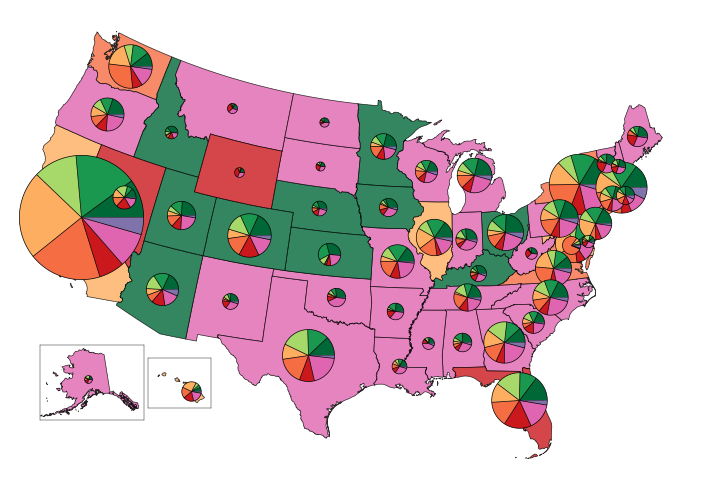

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(8,5))
max_size = 16169

gdf_state.plot(ax=axes, color=gdf_state['color_maxcluster'], edgecolor='k', alpha=0.8, linewidth=.5)

# Add Alaska and Hawaii
gdf_ak.to_crs({'init':'epsg:5936'}, inplace=True)
gdf_hi.to_crs({'init':'epsg:3759'}, inplace=True)

akax = fig.add_axes([0.1, 0.15, 0.15, 0.15])     
lns2 = gdf_ak.plot(ax=akax, color=gdf_ak['color_maxcluster'], edgecolor='k', alpha=0.8, linewidth=.5)

akax.set_xlim([0.5e6, 3.5e6])
akax.set_xticks([])
akax.set_yticks([])
for axis in ['top','bottom','left','right']:
    akax.spines[axis].set_linewidth(0.3)
    
hiax = fig.add_axes([0.235, 0.175, 0.1, 0.1]) 
lns2 = gdf_hi.plot(ax=hiax, color=gdf_hi['color_maxcluster'], edgecolor='k', alpha=0.8, linewidth=.5)

hiax.set_xlim([0.5e6, 3e6])
hiax.set_ylim([-1e6, 1e6])
hiax.set_xticks([])
hiax.set_yticks([])
for axis in ['top','bottom','left','right']:
    hiax.spines[axis].set_linewidth(0.3)
    
# Add pie charts
for state in ordered_states:
    
    ct_dict = combined_df_stations[combined_df_stations['State']==state]['Kmeans_nc8'].value_counts()
    ct_dict2 = {i:ct_dict[i] if i in ct_dict.keys() else 0 for i in range(8)}

    size_here = sum(ct_dict2.values())
    ratios_here = [ct_dict2[j]/size_here for j in cluster_order_numbers8_v3]
    colors_here = [colours_dict8_v3[j] for j in cluster_order_numbers8_v3]
    plot_size = size_here/max_size * 8000
    
    if state == 'HI':
        
        x_here = gdf_hi['geometry'].centroid.x
        y_here = gdf_hi['geometry'].centroid.y
        hiax = draw_pie(hiax, X=x_here, Y=y_here, size=plot_size, ratios=ratios_here, colors=colors_here)
        
    elif state == 'AK':
                
        x_here = gdf_ak['geometry'].centroid.x
        y_here = gdf_ak['geometry'].centroid.y
        akax = draw_pie(akax, X=x_here, Y=y_here, size=plot_size, ratios=ratios_here, colors=colors_here)
        
    else:

        x_here = gdf_state.loc[gdf_state[gdf_state['STUSPS']==state].index.values[0], 'geometry'].centroid.x
        y_here = gdf_state.loc[gdf_state[gdf_state['STUSPS']==state].index.values[0], 'geometry'].centroid.y

        axes = draw_pie(axes, X=x_here, Y=y_here, size=plot_size, ratios=ratios_here, colors=colors_here)
        
axes.axis('off')
plt.tight_layout()
plt.savefig('Figures/figure5a_clustersplit_state_map_withHIAK_'+plotsavedate+'.pdf', dpi=400, bbox_inches='tight')
plt.savefig('Figures/figure5a_clustersplit_state_map_withHIAK_'+plotsavedate+'.png', dpi=400, bbox_inches='tight')
plt.show()

### Legends

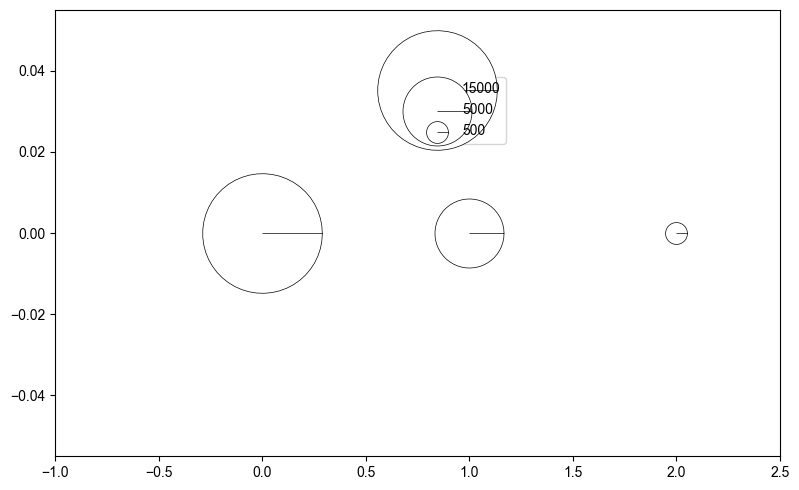

In [12]:
pltvals = [15000, 5000, 500]
fig, axes = plt.subplots(1, 1, figsize=(8,5))
for i in range(3):
    axes = draw_pie(axes, X=i, Y=0, size=pltvals[i]/max_size * 8000, colors=['white'], ratios=[1.0], label=pltvals[i])
    
plt.legend(loc=(0.5, 0.7))
plt.tight_layout()
plt.xlim([-1, 2.5])
plt.savefig('Figures/figure5a_size_legend_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.show()

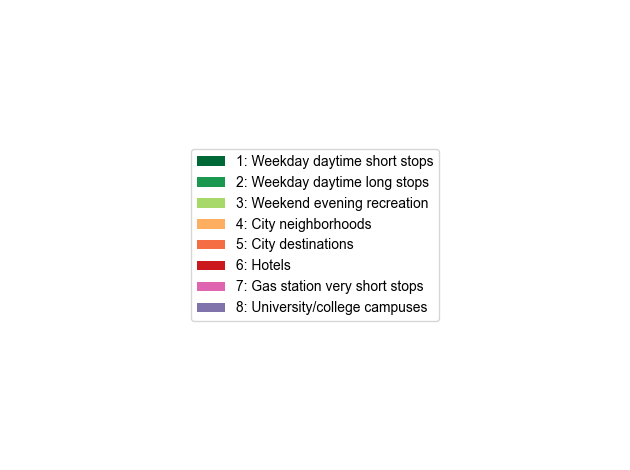

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colours_dict8_v3[j], label=str(i+1)+': '+label_mapping['Nice Names'][j]) for i, j in enumerate(cluster_order_numbers8_v3)]

fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')
ax.axis('off')
plt.tight_layout()
plt.savefig('Figures/figure5a_legend_clustering_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.show()